# Q-table RL Poker Agent

The concept is simply that the agent is given hands and it runs the hand X times, and it returns a % of hands won.

This is done with the Q-learning principle and formula for future rewards

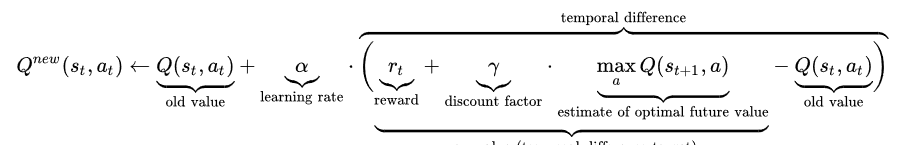

In [ ]:
import numpy as np
from collections import Counter
import random
from IPython.display import clear_output

The whole problem that this program solves is to capture the opponent range and take the action with the highest winning odds.
* Further progress would include bets and actually recording how your opponent acts. (which is probably the most important part)

Algorithm:
1. Determine range from previous plays and from the ammount enemy bets. (in each turn)
2. From range determine if you should call.
3. Repeat


### Building starting hand.
It will allways call in the first phase of the training 

In [ ]:
#Get the initial values from the environment

#starting hand

class MonteCarlInitial():
  def __init__(self, currentPlayingHand):
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self.currentPlayingHand = currentPlayingHand
    self.Win = False
    
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
    def _getHandsAsMinus1NotZero(self):
      for i in range(len(self.Hand)):
        self.Hand[i] = -1
      for i in range(len(self.EnemyHand)):
        self.EnemyHand[i] = -1

  
  def _get_Game(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   
    #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.
    inv_deckDic = {v: k for k, v in self.deckDic.items()}
    def handTextToNumber(currentPlayingHand):
      numHand = []
      for i in currentPlayingHand:
        if(i == -1):
          numHand.append(i)
        else:
          numHand.append(inv_deckDic[i])
      return numHand

    self.Hand = np.array(handTextToNumber(self.currentPlayingHand))

    self.Deck = np.setdiff1d(self.Deck,self.Hand[0])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[1])

    #now the enemy gets 2 cards
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[0] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[0])
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[1] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[1])

    #now goes the rest. (flop turn and river)
      
    #Add the flop to the two hands and remove from Deck
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[2] = self.Deck[DrawCard] 
    self.EnemyHand[2] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[2])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[3] = self.Deck[DrawCard] 
    self.EnemyHand[3] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[3])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[4] = self.Deck[DrawCard] 
    self.EnemyHand[4] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[4])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[5] = self.Deck[DrawCard] 
    self.EnemyHand[5] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[5])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[6] = self.Deck[DrawCard] 
    self.EnemyHand[6] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[6]) 

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank  

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False

  

### Testing the program

In [ ]:
currentPlayingHand = ["3d","2s",-1,-1,-1,-1,-1]

MCarl = MonteCarlInitial(currentPlayingHand)
MCarl._get_Game()
print("Hand Rank: ", MCarl._get_rank(MCarl.Hand))
print("EHand Rank: ", MCarl._get_rank(MCarl.EnemyHand))
MCarl._get_winner()
MCarl.Win

#### now you loop and get the percentages (simple MonteCarlo)

In [ ]:
currentPlayingHand = ["8c","6h",-1,-1,-1,-1,-1]
MCarl = MonteCarlInitial(currentPlayingHand)
wins = 0
loss = 0
for i in range(100):
  MCarl._get_Game()
  MCarl._get_winner()
  if(MCarl.Win == True):
    wins += 1
  else:
    loss += 1

print(wins/(wins+loss))

### Adding the flop

In [ ]:
#Get the initial values from the environment

#starting hand
#currentPlayingHand = ["9d","9s","10d","2s","3d",-1,-1]

class MonteCarlFlop():
  def __init__(self, currentPlayingHand):
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self.currentPlayingHand = currentPlayingHand
    self.Win = False
    
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
    def _getHandsAsMinus1NotZero(self):
      for i in range(len(self.Hand)):
        self.Hand[i] = -1
      for i in range(len(self.EnemyHand)):
        self.EnemyHand[i] = -1

  
  def _get_Game(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   
    #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.
    inv_deckDic = {v: k for k, v in self.deckDic.items()}
    def handTextToNumber(currentPlayingHand):
      numHand = []
      for i in currentPlayingHand:
        if(i == -1):
          numHand.append(i)
        else:
          numHand.append(inv_deckDic[i])
      return numHand

    self.Hand = np.array(handTextToNumber(self.currentPlayingHand))

    self.Deck = np.setdiff1d(self.Deck,self.Hand[0])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[1])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[2])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[3])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[4])

    #now the enemy gets 2 cards
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[0] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[0],0)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[1] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[1],0)
    #and then the 3 cards from the hand
    self.EnemyHand[2:] = self.Hand[2:]

    #now goes the rest. ( turn and river)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[5] = self.Deck[DrawCard] 
    self.EnemyHand[5] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[5])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[6] = self.Deck[DrawCard] 
    self.EnemyHand[6] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[6]) 

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank  

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False






### Testing flop

In [ ]:
currentPlayingHand = ["3d","3s","10s","4d","7s",-1,-1]

MCarl = MonteCarlFlop(currentPlayingHand)
MCarl._get_Game()
print("Hand Rank: ", MCarl._get_rank(MCarl.Hand))
print("EHand Rank: ", MCarl._get_rank(MCarl.EnemyHand))
MCarl._get_winner()
MCarl.Win

### Flop loop

In [ ]:
currentPlayingHand = ["13h","13s","7h","14c","11h",-1,-1]
MCarl = MonteCarlFlop(currentPlayingHand)
wins = 0
loss = 0
for i in range(100):
  MCarl._get_Game()
  MCarl._get_winner()
  if(MCarl.Win == True):
    wins += 1
  else:
    loss += 1

print(wins/(wins+loss))

### Turn loop


In [ ]:
#Get the initial values from the environment

#starting hand
#currentPlayingHand = ["9d","9s","10d","2s","3d","2d",-1]

class MonteCarlTurn():
  def __init__(self, currentPlayingHand):
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self.currentPlayingHand = currentPlayingHand
    self.Win = False
    
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
    def _getHandsAsMinus1NotZero(self):
      for i in range(len(self.Hand)):
        self.Hand[i] = -1
      for i in range(len(self.EnemyHand)):
        self.EnemyHand[i] = -1

  
  def _get_Game(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   
    #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.
    inv_deckDic = {v: k for k, v in self.deckDic.items()}
    def handTextToNumber(currentPlayingHand):
      numHand = []
      for i in currentPlayingHand:
        if(i == -1):
          numHand.append(i)
        else:
          numHand.append(inv_deckDic[i])
      return numHand

    self.Hand = np.array(handTextToNumber(self.currentPlayingHand))

    self.Deck = np.setdiff1d(self.Deck,self.Hand[0])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[1])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[2])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[3])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[4])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[5])

    #now the enemy gets 2 cards
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[0] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[0],0)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[1] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[1],0)
    #and then the 3 cards from the hand
    self.EnemyHand[2:] = self.Hand[2:]

    #now goes the rest. (river)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[6] = self.Deck[DrawCard] 
    self.EnemyHand[6] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[6]) 

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank  

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False



In [ ]:
currentPlayingHand = ["3d","3s","10s","4d","7s","3c",-1]

MCarl = MonteCarlTurn(currentPlayingHand)
MCarl._get_Game()
print("Hand Rank: ", MCarl._get_rank(MCarl.Hand))
print("EHand Rank: ", MCarl._get_rank(MCarl.EnemyHand))
MCarl._get_winner()
MCarl.Win

In [ ]:
currentPlayingHand = ["3d","3s","10s","4d","7s","3c",-1]
MCarl = MonteCarlTurn(currentPlayingHand)
wins = 0
loss = 0
for i in range(100):
  MCarl._get_Game()
  MCarl._get_winner()
  if(MCarl.Win == True):
    wins += 1
  else:
    loss += 1

print(wins/(wins+loss))

### River

In [ ]:
#Get the initial values from the environment

#starting hand
#currentPlayingHand = ["9d","9s","10d","2s","3d","2d","5d"]

class MonteCarlRiver():
  def __init__(self, currentPlayingHand):
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self.currentPlayingHand = currentPlayingHand
    self.Win = False
    
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
    def _getHandsAsMinus1NotZero(self):
      for i in range(len(self.Hand)):
        self.Hand[i] = -1
      for i in range(len(self.EnemyHand)):
        self.EnemyHand[i] = -1

  
  def _get_Game(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   
    #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.
    inv_deckDic = {v: k for k, v in self.deckDic.items()}
    def handTextToNumber(currentPlayingHand):
      numHand = []
      for i in currentPlayingHand:
        if(i == -1):
          numHand.append(i)
        else:
          numHand.append(inv_deckDic[i])
      return numHand

    self.Hand = np.array(handTextToNumber(self.currentPlayingHand))

    self.Deck = np.setdiff1d(self.Deck,self.Hand[0])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[1])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[2])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[3])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[4])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[5])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[6])

    #now the enemy gets 2 cards
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[0] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[0],0)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[1] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[1],0)
    #and then the 3 cards from the hand
    self.EnemyHand[2:] = self.Hand[2:]

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank  

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False






In [ ]:
currentPlayingHand = ["3d","3s","10s","4d","7s","3c","5d"]

MCarl = MonteCarlRiver(currentPlayingHand)
MCarl._get_Game()
print("Hand Rank: ", MCarl._get_rank(MCarl.Hand))
print("EHand Rank: ", MCarl._get_rank(MCarl.EnemyHand))
MCarl._get_winner()
MCarl.Win

In [ ]:
currentPlayingHand = ["3d","3s","10s","4d","7s","3c","5d"]
MCarl = MonteCarlRiver(currentPlayingHand)
wins = 0
loss = 0
for i in range(100):
  MCarl._get_Game()
  MCarl._get_winner()
  if(MCarl.Win == True):
    wins += 1
  else:
    loss += 1

print(wins/(wins+loss))

#### to check the odds against a third party calculator
https://www.888poker.com/poker/poker-odds-calculator

## Build enemy range

1. In this model the enemy hand is totally random.
2. In self.EnemyRangeDeck there are 2600+ card pairs, you can choose a % to simulate your opponent range. (They are ranked by common probability and opening hand strenght)

In [ ]:
#PokerHandRangeRanking:

#todas las cartas
StartingHandsOdds = []
suitDic = ["h","d","c","s"]
perc = 0
for suit in suitDic:
  print(perc*25)
  perc += 1
  for card in range(2,15):
    name1 = str(card) + suit
    #now get second card
    for s in suitDic:
      for cNum in range(2,15):
        name2 = str(cNum) + s
        if(name2 == name1):
          pass
        else:
          currentPlayingHand = [name1,name2, -1,-1,-1,-1,-1]
          MCarl = MonteCarlInitial(currentPlayingHand)
          wins = 0
          loss = 0
          for i in range(10):
            MCarl._get_Game()
            MCarl._get_winner()
            if(MCarl.Win == True):
              wins += 1
            else:
              loss += 1
          odds = wins/(wins+loss)
          hand = [name1,name2]
          StartingHandsOdds.append([odds,hand])

In [ ]:
sortedHandRange = sorted(StartingHandsOdds)

In [ ]:
#np.save("/content/sortedHandRange", sortedHandRange,allow_pickle=True)

In [ ]:
sortedHandRange = np.load('/content/sortedHandRange.npy', allow_pickle=True)

In [ ]:
sortedHandRange[2000][1]

In [ ]:
enemyHandIndex = random.randint(len(sortedHandRange)/2,len(sortedHandRange)-1)
enemyHandIndex
enemyHand = sortedHandRange[enemyHandIndex][1]
enemyHand


In [ ]:
print(sortedHandRange[int(len(sortedHandRange)/1.5)])
print(sortedHandRange[int(len(sortedHandRange)/2)])


## Ranged enemy.

In [ ]:
class MonteCarlInitialRanged():
  def __init__(self, currentPlayingHand,sortedHandRange,enemyrange):
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self.currentPlayingHand = currentPlayingHand
    self.Win = False
    self.sortedHandRange = sortedHandRange
    self.enemyrange = enemyrange
    
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
    def _getHandsAsMinus1NotZero(self):
      for i in range(len(self.Hand)):
        self.Hand[i] = -1
      for i in range(len(self.EnemyHand)):
        self.EnemyHand[i] = -1

  
  def _get_Game(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   
    #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.
    inv_deckDic = {v: k for k, v in self.deckDic.items()}
    def handTextToNumber(currentPlayingHand):
      numHand = []
      for i in currentPlayingHand:
        if(i == -1):
          numHand.append(i)
        else:
          numHand.append(inv_deckDic[i])
      return numHand

    self.Hand = np.array(handTextToNumber(self.currentPlayingHand))

    self.Deck = np.setdiff1d(self.Deck,self.Hand[0])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[1])

    #now the enemy gets 2 cards - From range 50%
    divRange = 1/(self.enemyrange/100)
    DrawCard = random.randint(int(len(self.sortedHandRange)/divRange),len(self.sortedHandRange)-1)
    self.EnemyHand[0] = np.array(handTextToNumber(self.sortedHandRange[DrawCard][1]))[0]
    self.EnemyHand[1] = np.array(handTextToNumber(self.sortedHandRange[DrawCard][1]))[1]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[0])
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[1])

    #now goes the rest. (flop turn and river)
      
    #Add the flop to the two hands and remove from Deck
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[2] = self.Deck[DrawCard] 
    self.EnemyHand[2] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[2])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[3] = self.Deck[DrawCard] 
    self.EnemyHand[3] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[3])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[4] = self.Deck[DrawCard] 
    self.EnemyHand[4] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[4])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[5] = self.Deck[DrawCard] 
    self.EnemyHand[5] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[5])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[6] = self.Deck[DrawCard] 
    self.EnemyHand[6] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[6]) 

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank  

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False

Ranged Flop

In [ ]:
#Get the initial values from the environment

#starting hand
#currentPlayingHand = ["9d","9s","10d","2s","3d",-1,-1]

class MonteCarlFlopRanged():
  def __init__(self, currentPlayingHand,sortedHandRange,enemyrange):
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self.currentPlayingHand = currentPlayingHand
    self.Win = False
    self.sortedHandRange = sortedHandRange
    self.enemyrange = enemyrange
    
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
    def _getHandsAsMinus1NotZero(self):
      for i in range(len(self.Hand)):
        self.Hand[i] = -1
      for i in range(len(self.EnemyHand)):
        self.EnemyHand[i] = -1

  
  def _get_Game(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   
    #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.
    inv_deckDic = {v: k for k, v in self.deckDic.items()}
    def handTextToNumber(currentPlayingHand):
      numHand = []
      for i in currentPlayingHand:
        if(i == -1):
          numHand.append(i)
        else:
          numHand.append(inv_deckDic[i])
      return numHand

    self.Hand = np.array(handTextToNumber(self.currentPlayingHand))

    self.Deck = np.setdiff1d(self.Deck,self.Hand[0])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[1])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[2])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[3])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[4])

    #now the enemy gets 2 cards - From range 50%
    divRange = 1/(self.enemyrange/100)
    DrawCard = random.randint(int(len(self.sortedHandRange)/divRange),len(self.sortedHandRange)-1)
    self.EnemyHand[0] = np.array(handTextToNumber(self.sortedHandRange[DrawCard][1]))[0]
    self.EnemyHand[1] = np.array(handTextToNumber(self.sortedHandRange[DrawCard][1]))[1]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[0])
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[1])
    self.EnemyHand[2:] = self.Hand[2:]

    #now goes the rest. ( turn and river)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[5] = self.Deck[DrawCard] 
    self.EnemyHand[5] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[5])

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[6] = self.Deck[DrawCard] 
    self.EnemyHand[6] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[6]) 

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank  

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False


Turn enemy ranged

In [ ]:
#Get the initial values from the environment

#starting hand
#currentPlayingHand = ["9d","9s","10d","2s","3d","2d",-1]

class MonteCarlTurnRanged():
  def __init__(self, currentPlayingHand,sortedHandRange, enemyrange):
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self.currentPlayingHand = currentPlayingHand
    self.Win = False
    self.sortedHandRange = sortedHandRange
    self.enemyrange = enemyrange

    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
    def _getHandsAsMinus1NotZero(self):
      for i in range(len(self.Hand)):
        self.Hand[i] = -1
      for i in range(len(self.EnemyHand)):
        self.EnemyHand[i] = -1

  
  def _get_Game(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   
    #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.
    inv_deckDic = {v: k for k, v in self.deckDic.items()}
    def handTextToNumber(currentPlayingHand):
      numHand = []
      for i in currentPlayingHand:
        if(i == -1):
          numHand.append(i)
        else:
          numHand.append(inv_deckDic[i])
      return numHand

    self.Hand = np.array(handTextToNumber(self.currentPlayingHand))

    self.Deck = np.setdiff1d(self.Deck,self.Hand[0])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[1])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[2])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[3])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[4])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[5])

    #now the enemy gets 2 cards - From range 50%
    divRange = 1/(self.enemyrange/100)
    DrawCard = random.randint(int(len(self.sortedHandRange)/divRange),len(self.sortedHandRange)-1)
    self.EnemyHand[0] = np.array(handTextToNumber(self.sortedHandRange[DrawCard][1]))[0]
    self.EnemyHand[1] = np.array(handTextToNumber(self.sortedHandRange[DrawCard][1]))[1]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[0])
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[1])
    self.EnemyHand[2:] = self.Hand[2:]

    #now goes the rest. (river)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[6] = self.Deck[DrawCard] 
    self.EnemyHand[6] = self.Deck[DrawCard]
    self.Deck = np.setdiff1d(self.Deck,self.Hand[6]) 

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank  

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False


River enemy ranged

In [ ]:
#Get the initial values from the environment

#starting hand
#currentPlayingHand = ["9d","9s","10d","2s","3d","2d","5d"]

class MonteCarlRiverRanged():
  def __init__(self, currentPlayingHand, sortedHandRange,enemyrange):
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self.currentPlayingHand = currentPlayingHand
    self.Win = False
    self.sortedHandRange = sortedHandRange
    self.enemyrange = enemyrange
    
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
    def _getHandsAsMinus1NotZero(self):
      for i in range(len(self.Hand)):
        self.Hand[i] = -1
      for i in range(len(self.EnemyHand)):
        self.EnemyHand[i] = -1

  
  def _get_Game(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   
    #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.
    inv_deckDic = {v: k for k, v in self.deckDic.items()}
    def handTextToNumber(currentPlayingHand):
      numHand = []
      for i in currentPlayingHand:
        if(i == -1):
          numHand.append(i)
        else:
          numHand.append(inv_deckDic[i])
      return numHand

    self.Hand = np.array(handTextToNumber(self.currentPlayingHand))

    self.Deck = np.setdiff1d(self.Deck,self.Hand[0])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[1])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[2])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[3])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[4])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[5])
    self.Deck = np.setdiff1d(self.Deck,self.Hand[6])

    #now the enemy gets 2 cards - From range 50%
    divRange = 1/(self.enemyrange/100)
    DrawCard = random.randint(int(len(self.sortedHandRange)/divRange),len(self.sortedHandRange)-1)
    self.EnemyHand[0] = np.array(handTextToNumber(self.sortedHandRange[DrawCard][1]))[0]
    self.EnemyHand[1] = np.array(handTextToNumber(self.sortedHandRange[DrawCard][1]))[1]
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[0])
    self.Deck = np.setdiff1d(self.Deck,self.EnemyHand[1])
    self.EnemyHand[2:] = self.Hand[2:]

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank  

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False






### Merge the training loops

In [ ]:
def startLoop(currentPlayingHand,sortedHandRange,enemyrange):
  MCarl = MonteCarlInitialRanged(currentPlayingHand,sortedHandRange,enemyrange)
  wins = 0
  loss = 0
  for i in range(300):
    MCarl._get_Game()
    MCarl._get_winner()
    if(MCarl.Win == True):
      wins += 1
    else:
      loss += 1

  return(wins/(wins+loss))

def flopLoop(currentPlayingHand,sortedHandRange,enemyrange):
  MCarl = MonteCarlFlopRanged(currentPlayingHand,sortedHandRange,enemyrange)
  wins = 0
  loss = 0
  for i in range(300):
    MCarl._get_Game()
    MCarl._get_winner()
    if(MCarl.Win == True):
      wins += 1
    else:
      loss += 1

  return(wins/(wins+loss))

def turnLoop(currentPlayingHand,sortedHandRange,enemyrange):
  MCarl = MonteCarlTurnRanged(currentPlayingHand,sortedHandRange,enemyrange)
  wins = 0
  loss = 0
  for i in range(300):
    MCarl._get_Game()
    MCarl._get_winner()
    if(MCarl.Win == True):
      wins += 1
    else:
      loss += 1

  return(wins/(wins+loss))

def riverLoop(currentPlayingHand,sortedHandRange,enemyrange):
  MCarl = MonteCarlRiverRanged(currentPlayingHand,sortedHandRange,enemyrange)
  wins = 0
  loss = 0
  for i in range(300):
    MCarl._get_Game()
    MCarl._get_winner()
    if(MCarl.Win == True):
      wins += 1
    else:
      loss += 1
  return(wins/(wins+loss))

### The training loops

In [ ]:
currentPlayingHand = ["14s","9c","10c","10h","12c","5s","6c"]

In [ ]:
startLoop(currentPlayingHand,sortedHandRange,90)

In [ ]:
flopLoop(currentPlayingHand,sortedHandRange,90)

In [ ]:
turnLoop(currentPlayingHand,sortedHandRange,90)

In [ ]:
riverLoop(currentPlayingHand,sortedHandRange,90)

In [ ]:
class pokerEnv():
  def __init__(self):
    self.action_space = 2 #You can either do call or fold.
    self.observation_space = np.zeros((53*7)) #2 cards on hand + board #antes era 7, pero lo camie a 52*7 porque el one-hot encoder + -1 de empty
    self.totalReward = 0
    self.Deck = np.zeros((52))
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))

    self.Call = False
    self.Done = False
    self.Win = False
    
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

    def _build_card_dic(self):
      deckDic = {}
      suitDic = ["h","d","c","s"]
      x = 0
      for suit in range(4):
        for card in range(2,15):
          name = str(card) + suitDic[suit]
          deckDic[x] = name
          x += 1
      return deckDic
    self.deckDic = {}
    self.deckDic = _build_card_dic(self)
  
  def _getHandsAsMinus1NotZero(self):
    for i in range(len(self.Hand)):
      self.Hand[i] = -1
    for i in range(len(self.EnemyHand)):
      self.EnemyHand[i] = -1

  def _build_Deck(self):
    self.Deck = np.zeros((52))
    for izz in range(52):
      self.Deck[izz] = izz   

  def _get_starting_hands(self):
    self._build_Deck()
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[0] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[1] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)

    #Now the enemy
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[0] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.EnemyHand[1] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)  

  def _get_flop(self):
    #Add the flop to the two hands and remove from Deck
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[2] = self.Deck[DrawCard] 
    self.EnemyHand[2] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[3] = self.Deck[DrawCard] 
    self.EnemyHand[3] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)

    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[4] = self.Deck[DrawCard] 
    self.EnemyHand[4] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)
  
  def _get_turn(self):
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[5] = self.Deck[DrawCard] 
    self.EnemyHand[5] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)
  
  def _get_river(self):
    DrawCard = random.randint(0,len(self.Deck)-1)
    self.Hand[6] = self.Deck[DrawCard] 
    self.EnemyHand[6] = self.Deck[DrawCard]
    self.Deck = np.delete(self.Deck,DrawCard,0)

  def _get_rank(self, evaluatedHand):
    evaluatedHandStrings = []
    for i in range(len(evaluatedHand)):
      evaluatedHandStrings.append(self.deckDic[evaluatedHand[i]])
    evaluatedHandSuits = []
    evaluatedHandNumbers = []   
    for i in range(len(evaluatedHandStrings)):
      evaluatedHandNumbers.append(int(evaluatedHandStrings[i][:-1]))
      evaluatedHandSuits.append(evaluatedHandStrings[i][-1])
    numDic = Counter(evaluatedHandNumbers)
    suitDic = Counter(evaluatedHandSuits)
    #empezamos por los pares, tercias y cuatros.
    highCard = 2
    pairCount = 0
    pairArray = []
    pair = False
    doublePair = False
    tripleCount = 0
    tripleArray = []
    triple = False
    fourCount = 0
    fourArray = []
    four = False
    for i in numDic:
      if(numDic[i] == 2):
        pairCount += 1
        pairArray.append(i)
        pair = True
        if(pairCount >= 2):
          pair = False
          doublePair = True
      if(numDic[i] == 3): #just take highest, there is no two triples hand
        tripleCount += 1
        tripleArray.append(i)
        triple = True
      if(numDic[i] == 4):
        fourCount = 1
        fourArray.append(i)
        four = True
      if(int(i) > highCard):
        highCard = int(i)
    #detect flush
    flush = False
    for i in suitDic: 
      if(suitDic[i] >= 5):
        flush = True
        #print("flush: ", flush)
        flushHighest = 2
        for z in evaluatedHandStrings:
          if(z[-1] == i):
            if(int(z[:-1]) > flushHighest):
              flushHighest = int(z[:-1])
        suit = i
    #detect straight:
    straight = False
    sortedHandNumbers = sorted(evaluatedHandNumbers)
    #print(sortedHandNumbers)
    previ = sortedHandNumbers[0]
    straightCount = 1
    maxStraightCard = 2
    for i in sortedHandNumbers:
      #print("pi: ",previ, " i: ", i )
      if i == previ:
        pass
      elif previ+1 == i:
        straightCount += 1
        if(i > maxStraightCard):
          maxStraightCard = i
        if straightCount >= 5:
          straight = True
          #print("Straight: ", straight)
      else:
        straightCount = 1
      previ = i


    #Detect combinations
    #Full
    full = False
    if(pairCount >= 1 and tripleCount >=1):
      full = True
      fullArray =  [pairArray,tripleArray]

    #StraightAndRoyalFlush
    straightFlush = False
    straightSuitCount = 0
    royalFlush = False
    if(flush == True and straight == True):
    #Check if the straight has the flush
      sameSuitCardsNumbersArray = []
      for i in evaluatedHandStrings: #now that you have the flush numbers, check if straight.
        if(suit == i[-1]):
          sameSuitCardsNumbersArray.append(int(i[:-1]))
      #check if straight
      sameSuitCardsNumbersArraySorted = sorted(sameSuitCardsNumbersArray)
      previ = sameSuitCardsNumbersArraySorted[0]
      flushStraightCount = 1
      maxFlushStraightCard = 2
      for i in sameSuitCardsNumbersArraySorted:
        #print("pi: ",previ, " i: ", i )
        if i == previ:
          pass
        elif previ+1 == i:
          flushStraightCount += 1
          if(i > maxFlushStraightCard):
            maxFlushStraightCard = i
          if flushStraightCount >= 5:
            straightFlush = True
        else:
          straightCount = 1
        previ = i
      if(maxFlushStraightCard == 14):
        royalFlush = True
      #print("sf: ", straightFlush," rf: ",royalFlush)


    if(royalFlush == True):
      returnArrRank = ["royalFlush",10]
      return returnArrRank
    elif(straightFlush == True):
      returnArrRank = ["straightFlush",9, maxFlushStraightCard, highCard]
      return returnArrRank
    elif(four == True):
      returnArrRank = ["four",8, fourArray, highCard]  
      return returnArrRank
    elif(full == True):
      returnArrRank = ["full",7, fullArray]
      return returnArrRank
    elif(flush == True):
      returnArrRank = ["flush",6, flushHighest]
      return returnArrRank 
    elif(straight == True):
      returnArrRank = ["straight",5, maxStraightCard]
      return returnArrRank
    elif(triple == True):
      returnArrRank = ["triple",4, tripleArray, highCard]
      return returnArrRank
    elif(doublePair == True):
      returnArrRank = ["doublePair",3, pairArray, highCard]
      return returnArrRank
    elif(pair == True):
      returnArrRank = ["pair",2, pairArray, highCard]
      return returnArrRank
    else:
      returnArrRank = ["highCard",1, sortedHandNumbers]
      return returnArrRank    

  def _get_winner(self):
    #Basicamente aquí tomas el rank de Hand y enemy.
    #Si tienen lo mismo y merita extra inquisition, se hace
    handValue = self._get_rank(self.Hand)
    enemyHandValue = self._get_rank(self.EnemyHand)
    self.Over = True
    if(handValue[1] > enemyHandValue[1]):
      self.Win = True
    elif(handValue[1] == enemyHandValue[1]): #todos los esenarios donde tu tienes igual que el enemigo.
      if(handValue[1] == 10): #si tienes royal flush ganas allways.
        self.Win = True
      elif(handValue[1] == 9): #si tienes straight flush
        if(handValue[2] >= enemyHandValue[2]): #comparas con flushHighest card. Si son iguales o tuya mayor, ganas.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 8): #si tienen 4 y tu carta es mayor que el enemigo.
        if(handValue[2][0] > enemyHandValue[2][0]): #aqui el array solo es de 1, nunca puedes tener 2 pokers.
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]): #si son iguales.
          if(handValue[3] >= enemyHandValue[3]): #si tu high card es mayor
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 7): #si tienes full
        if(handValue[2][1] >= enemyHandValue[2][1]): #si tu carta de tercia es mayor o igual a la del enemigo.
          self.Win = True
        else:
          self.Win = False #si no pierdes.             

      elif(handValue[1] == 6): #flush
        if(handValue[2] >= enemyHandValue[2]): #si tu carta mayor de flush es mayor a la del enemigo.
          self.Win = True
        else:
          self.Win = False

      elif(handValue[1] == 5):
        if(handValue[2] >= enemyHandValue[2]):
          self.Win = True
        else:
          self.Win = False
      elif(handValue[1] == 4):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False
      elif(handValue[1] == 3):
        handPairMax = 2
        handPairSecond = 2
        enemyHandPairMax = 2
        enemyHandPairSecond = 2
        for zi in range(len(handValue[2])):
          if(handValue[2][zi] > handPairMax):
            handPairMax = handValue[2][zi]
          if(handValue[2][zi] > handPairSecond and handValue[2][zi] < handPairMax):
            handPairSecond = handValue[2][zi]
        for zi in range(len(enemyHandValue[2])):
          if(enemyHandValue[2][zi] > enemyHandPairMax):
            enemyHandPairMax = enemyHandValue[2][zi]
          if(enemyHandValue[2][zi] > enemyHandPairSecond and enemyHandValue[2][zi] < enemyHandPairMax):
            enemyHandPairSecond = enemyHandValue[2][zi]
        
        if(handPairMax > enemyHandPairMax):
          self.Win = True
        elif(handPairMax == enemyHandPairMax):
          if(handPairSecond > enemyHandPairSecond):
            self.Win = True
          elif(handPairSecond == enemyHandPairSecond):
            if(handValue[3] >= enemyHandValue[3]):
              self.Win = True
            else:
              self.Win = False
          else:
            self.Win = False
        else:
          self.Win = False


      elif(handValue[1] == 2):
        if(handValue[2][0] > enemyHandValue[2][0]):
          self.Win = True
        elif(handValue[2][0] == enemyHandValue[2][0]):
          if(handValue[3] >= enemyHandValue[3]):
            self.Win = True
          else:
            self.Win = False
        else:
          self.Win = False

      elif(handValue[1] == 1):
        for ii in range(len(handValue[2])-1,1,-1):
          if(handValue[2][ii] >= enemyHandValue[2][ii]):
            self.Win = True
          else:
            self.Win = False
    else:
      self.Win = False



  def _get_reward(self):
    if(self.Call == True): #if you called
      if(self.Hand[6] != -1): #if after the last one was shown, you called, because you took the desition to
        self._get_winner() #check if you won
        if(self.Win == True):
          self.Done = True
          return 14 #win reward
        else:
          self.Done = True
          return -12 #loss reward. If, at showdown, you dont win, you loose.
      else:
        return 0 #what you get from calling before the end.
    else: #if at any point you folded. You have 4 chances to fold at any poker game. 
      self.Done = True
      return -1
      
      

  def _get_state(self):
    ob = self.Hand
    return ob        

  def _take_action(self, action): #Call = 1, fold = 0 #que pasa con cada acción. Solo se define si sigues o no.
    if(action == 1):
      self.Call = True
    else:
      self.Call = False
      

  def step(self,action):
    self._take_action(action)
    reward = self._get_reward()
    self.totalReward += reward
    
    if(self.Hand[2] == -1):
      self._get_flop()
    elif(self.Hand[5] == -1):
      self._get_turn()
    elif(self.Hand[6] == -1):
      self._get_river() #cuando acaba este loop ya toma la ultima desicion de si ir o no. Cuando inicie el siguiente step ya tenemos nuestra cuarta decision
      #despues de esta todavía necesita otro paso, que es el revisar si gana...
    #despues de el anterior elif todavía pasa 1 vez el loop, que es después de haber tomado la ultima desicion

    obs = self._get_state()
    return obs, reward, self.Done, {}

  def reset(self):
    self.Deck = _
    self.Hand = np.zeros((7))
    self.EnemyHand = np.zeros((7))
    self._getHandsAsMinus1NotZero()
    if(self.Hand[0] == -1): #if the game just started. This is the first state. You seeing your cards.
      self._get_starting_hands()
    self.Done = False
    self.Win = False ###????


    return self._get_state()

### Testing

In [ ]:
env = pokerEnv()

In [ ]:


deckDic = {}
suitDic = ["h","d","c","s"]
x = 0
for suit in range(4):
  for card in range(2,15):
    name = str(card) + suitDic[suit]
    deckDic[x] = name
    x += 1

Deck = np.zeros((52))
for izz in range(52):
  Deck[izz] = izz   
  #despues de iniciar tu deck sacas los numeros de la mano que quieres jugar.

inv_deckDic = {v: k for k, v in deckDic.items()}


In [ ]:
def get_action(obs, limit):
  currentPlayingHand = []
  for i in (obs):
    if i == -1:
      currentPlayingHand.append(i)
    else:
      currentPlayingHand.append(deckDic[i])
  if(obs[2] < 0):
    value = startLoop(currentPlayingHand,sortedHandRange,70)
  elif(obs[5] < 0):
    value = flopLoop(currentPlayingHand,sortedHandRange,70)
  elif(obs[6] < 0):
    value = turnLoop(currentPlayingHand,sortedHandRange,70)
  else:
    value = riverLoop(currentPlayingHand,sortedHandRange,70)
  
  if(value > limit):
    return 1, value
  else:
    return 0, value
    
   




In [ ]:
def numToText(obs):
  currentPlayingHand = []
  for i in (obs):
    if i == -1:
      currentPlayingHand.append(i)
    else:
      currentPlayingHand.append(deckDic[i])
  return currentPlayingHand

In [ ]:
winArray = []
winCount = 0
foldB4Flop = 0
foldFlop = 0
foldTurn = 0
foldRiver = 0
loss = 0
for x in range(1000):
  obs, done, ep_reward = env.reset(), False, 0 #Get the initial values from the environment
  actionsArray = []
  while not done:
    action, value = get_action(obs,.5) #returns the action the model recomends and a value? (What is the value for?)
    actionsArray.append(action)
    obs, reward, done, _ = env.step(action)
    if(done == True and env.Win == False):
      if(len(actionsArray) == 1):
        foldB4Flop += 1
      elif(len(actionsArray) == 2):
        foldFlop += 1
      elif(len(actionsArray) == 3):
        foldTurn += 1
      elif(len(actionsArray) == 4 and actionsArray[-1] == 0):
        foldRiver += 1
      elif(len(actionsArray) == 4 and actionsArray[-1] == 1):
        loss += 1
  
  if(env.Win == True):
    winCount += 1
  winArray.append(env.Win)

In [ ]:
print(winCount)
print(foldB4Flop)
print(foldFlop)
print(foldTurn)
print(foldRiver)
print(loss)

In [ ]:
obs, done, ep_reward = env.reset(), False, 0 #Get the initial values from the environment
actionsArray = []
while not done:
  action, value = get_action(obs,.5) #returns the action the model recomends and a value? (What is the value for?)
  print(obs)
  print(action)
  actionsArray.append(action)
  obs, reward, done, _ = env.step(action)